# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import uuid


import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix


# Cleaning working directory

In [2]:
DATASET_URL = 'https://github.com/Somertonman/hackathon/archive/refs/heads/main.zip'
LABELS = ['001_018','019_065','065_110']
TEMP_DIR = '/content/temp'
RAW_FILES_DIR = '/content/temp/raw_image_files'
TEST_ROOT = '/content/test'
TRAIN_ROOT = '/content/train'

# remove and recreate dirs

!rm -rf /content/*
!mkdir $TEMP_DIR
!mkdir $RAW_FILES_DIR
!mkdir $TRAIN_ROOT
!mkdir $TEST_ROOT

# Dataset download

In [3]:
# download file

%%capture
!wget $DATASET_URL -O $TEMP_DIR/main.zip

In [4]:
# unzip file

%%capture
!unzip -o -q $TEMP_DIR/main.zip -d $RAW_FILES_DIR/

In [5]:
raw_folders = glob(RAW_FILES_DIR + '/hackathon-main/dataset/no_mask/*') + glob(RAW_FILES_DIR + '/hackathon-main/dataset/with_mask/*')
raw_folders

['/content/temp/raw_image_files/hackathon-main/dataset/no_mask/nomask_001_018',
 '/content/temp/raw_image_files/hackathon-main/dataset/no_mask/nomask_019_065',
 '/content/temp/raw_image_files/hackathon-main/dataset/no_mask/nomask_066_110',
 '/content/temp/raw_image_files/hackathon-main/dataset/with_mask/mask_019_065',
 '/content/temp/raw_image_files/hackathon-main/dataset/with_mask/mask_066_110',
 '/content/temp/raw_image_files/hackathon-main/dataset/with_mask/mask_001_018']

# Dataset analysis

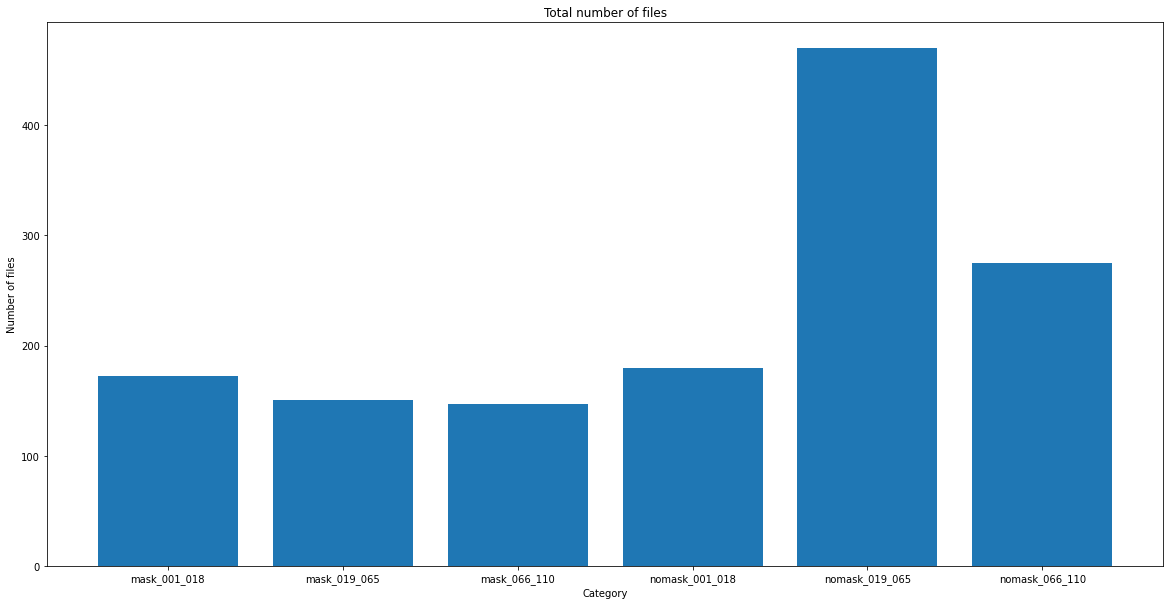

In [6]:
raw_stat = {}

for dirname in raw_folders:
    raw_stat[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

ages_dict = dict(sorted(raw_stat.items()))
plt.figure(figsize=(20, 10))
plt.title("Total number of files")
plt.xlabel("Category")
plt.ylabel("Number of files")
plt.bar(list(ages_dict.keys()), list(ages_dict.values()))
plt.show()


# Sampling and grouping to folders

In [7]:
max_sample_size_possible = min(ages_dict.values())
print("Max number of files for every class sample:", max_sample_size_possible)

Max number of files for every class sample: 147


In [8]:
# can't be bigger than 147 here

NUMBER_OF_MASK_FILES = 147
NUMBER_OF_NO_MASK_FILES = 147

total_number_of_files = NUMBER_OF_MASK_FILES + NUMBER_OF_NO_MASK_FILES

if NUMBER_OF_MASK_FILES > max_sample_size_possible or NUMBER_OF_NO_MASK_FILES > max_sample_size_possible:
  raise ValueError('Number of files in any group shoould be less than max_sample_size_possible.')
  


In [9]:
samples_dict = {'001_018':[], '019_065':[], '066_110':[]}

random.seed(10)

for dirname in raw_folders:
  folder_name = dirname.rsplit('/')[-1]
  mask_type, age_group = folder_name.split("_", 1)
  group_size = NUMBER_OF_MASK_FILES if mask_type == 'mask' else NUMBER_OF_NO_MASK_FILES
  dirglob = glob(dirname + '/*')
  group_sample = random.sample(dirglob, group_size)
  samples_dict[age_group].extend(group_sample)

# Test/train split

In [10]:
# percentage of both masked and nomasked images for test/train split
TRAIN_SPLIT_AT = 0.8

n_of_train_files = int(total_number_of_files * TRAIN_SPLIT_AT)

random.seed(10)

for age_range, filenames in samples_dict.items():
    Path(f"{TEST_ROOT}/{age_range}").mkdir(parents=True, exist_ok=True)
    Path(f"{TRAIN_ROOT}/{age_range}").mkdir(parents=True, exist_ok=True)

    random.shuffle(filenames)
    train_sample = filenames[:n_of_train_files]
    test_sample = filenames[n_of_train_files:]

    for f in train_sample:
      filename = str(uuid.uuid4()) + '.png'
      full_path = f"{TRAIN_ROOT}/{age_range}/{filename}"
      copyfile(f, full_path)

    for f in test_sample:
      filename = str(uuid.uuid4()) + '.png'
      full_path = f"{TEST_ROOT}/{age_range}/{filename}"
      copyfile(f, full_path)  

# Groups stats and preview

In [46]:
# useful for getting number of files
train_files = glob(TRAIN_ROOT + '/*/*.png')
test_files = glob(TEST_ROOT + '/*/*.png')
print('Train files total:', len(train_files))
print('Test files total:', len(test_files))


Train files total: 705
Test files total: 177


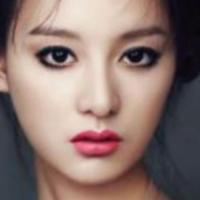

In [13]:
from PIL import Image
im = Image.open(np.random.choice(train_files))
display(im)


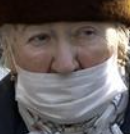

In [47]:
im = Image.open(np.random.choice(test_files))
display(im)


# Model set up

In [15]:
# re-size all the images to this
IMAGE_SIZE = [200, 200]

# training config:
epochs = 64
batch_size = 64


# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(LABELS), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [17]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [18]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(TEST_ROOT, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 177 images belonging to 3 classes.
{'001_018': 0, '019_065': 1, '066_110': 2}


In [19]:
# create generators
train_generator = train_gen.flow_from_directory(
  TRAIN_ROOT,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  TEST_ROOT,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 705 images belonging to 3 classes.
Found 177 images belonging to 3 classes.


# Training

In [20]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

Epoch 1/64
11/11 [==============================] - 26s 1s/step - loss: 16.3548 - accuracy: 0.4034 - val_loss: 4.4055 - val_accuracy: 0.7031
Epoch 2/64
11/11 [==============================] - 12s 1s/step - loss: 5.1077 - accuracy: 0.6646 - val_loss: 2.1216 - val_accuracy: 0.8125
Epoch 3/64
11/11 [==============================] - 12s 1s/step - loss: 2.3774 - accuracy: 0.7685 - val_loss: 2.3703 - val_accuracy: 0.7422
Epoch 4/64
11/11 [==============================] - 12s 1s/step - loss: 1.8090 - accuracy: 0.8268 - val_loss: 3.0241 - val_accuracy: 0.8047
Epoch 5/64
11/11 [==============================] - 12s 1s/step - loss: 1.7648 - accuracy: 0.8268 - val_loss: 6.0931 - val_accuracy: 0.6641
Epoch 6/64
11/11 [==============================] - 12s 1s/step - loss: 1.8344 - accuracy: 0.8315 - val_loss: 3.2650 - val_accuracy: 0.7422
Epoch 7/64
11/11 [==============================] - 12s 1s/step - loss: 1.5393 - accuracy: 0.8549 - val_loss: 3.2962 - val_accuracy: 0.7422
Epoch 8/64
11/11 [=

# Training speed/quality

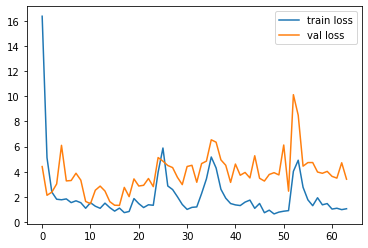

In [22]:
# loss
plt.plot(r.history['loss'], label='train loss')
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

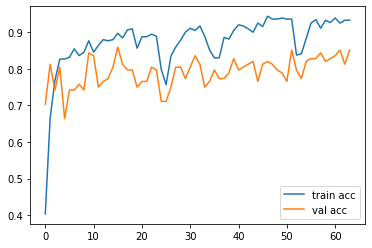

In [23]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

# Confusion matrix

In [24]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [28]:
cm = get_confusion_matrix(TRAIN_ROOT, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(TEST_ROOT, len(test_files))
print(valid_cm)

Generating confusion matrix 705
Found 705 images belonging to 3 classes.
[[226   8   1]
 [  5 226   4]
 [  0   7 228]]
Generating confusion matrix 177
Found 177 images belonging to 3 classes.
[[49 10  0]
 [ 3 52  4]
 [ 1  6 52]]


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[226   8   1]
 [  5 226   4]
 [  0   7 228]]


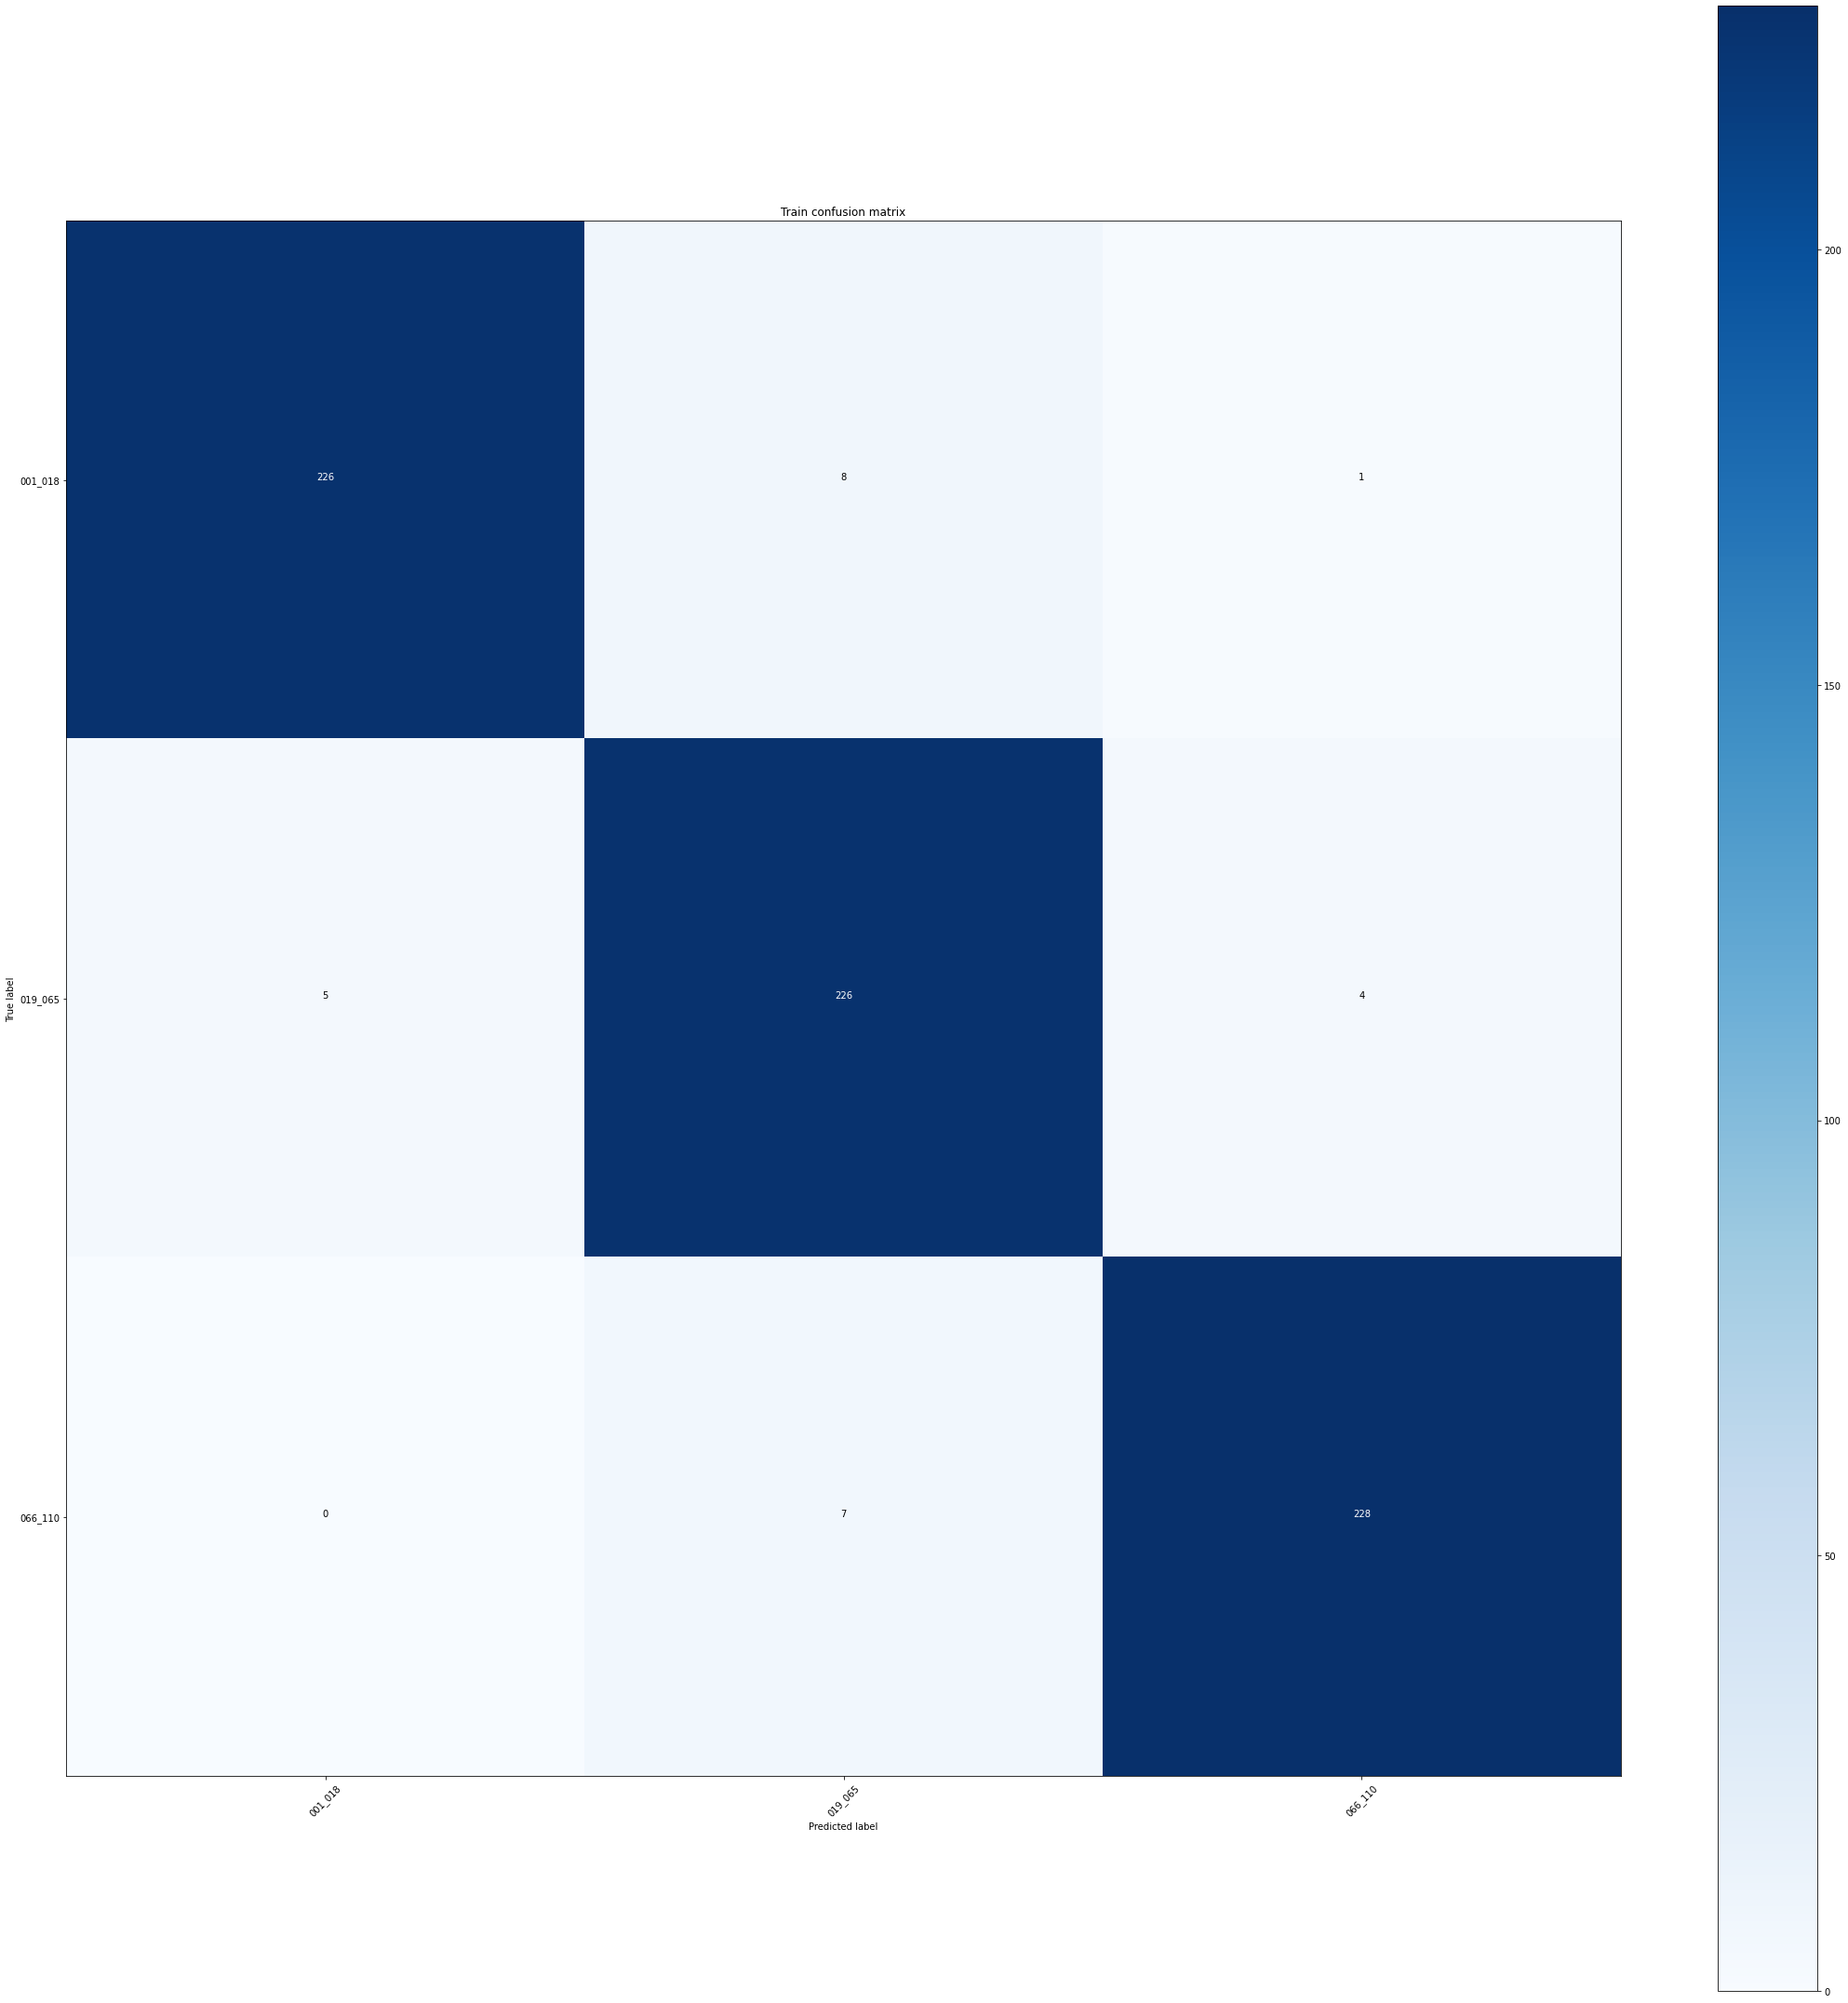

In [29]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


# Save/load model

In [28]:
#model.save('faces.h5')

#model = load_model('faces.h5')

# Testing with random images

In [32]:
import requests, io, cv2
import numpy as np
from PIL import Image


https://cdn11.bigcommerce.com/s-546g635i24/images/stencil/1280x1280/products/209/927/Shark_02_0734120__81266.1596763852.jpg?c=2
Predicted age group: 001_018


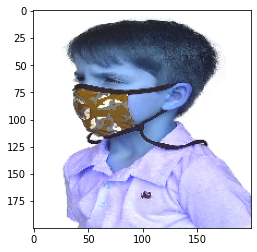

In [48]:
URL = input()
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_RGB2BGR)

IMAGE_SIZE = (200,200)
internal_image = cv2.resize(cv_im,IMAGE_SIZE)
internal_image = internal_image.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1],3) 


plt.imshow(internal_image[0])
p = np.argmax(model.predict(internal_image))
print('Predicted age group:', labels[p])

In [90]:
# model1 = tf.keras.models.load_model('/content/model_35_32_79.h5')
# p = np.argmax(model1.predict(internal_image))
# print('Predicted age group:', labels[p])

# model2 = tf.keras.models.load_model('/content/model_35_64_81.h5')
# p = np.argmax(model2.predict(internal_image))
# print('Predicted age group:', labels[p])

# model3 = tf.keras.models.load_model('/content/model_64_64_83.h5')
# p = np.argmax(model3.predict(internal_image))
# print('Predicted age group:', labels[p])

Predicted age group: 019_065
Predicted age group: 001_018
Predicted age group: 019_065
